In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.preprocessing import OneHotEncoder
#from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
train_data = pd.read_csv("../input/digit-recognizer/train.csv")
tr_y = train_data.pop("label")
#tr_y = y.values.reshape(-1, 1)
tr_X = train_data/255.0
X = tr_X.values.reshape(42000, 28, 28, 1)
train_X = X[0:37000, :, :, :]
val_X = X[37000:42000, :, :, :]
print("Training data shape: ", train_X.shape)
print("Validating data shape: ", val_X.shape)
test_data = pd.read_csv("../input/digit-recognizer/test.csv")
input_shape = [train_X.shape[1]]

Training data shape:  (37000, 28, 28, 1)
Validating data shape:  (5000, 28, 28, 1)


In [3]:
#OH_Enc = OneHotEncoder()
#trn_y = OH_Enc.fit_transform(tr_y)
train_y = tr_y[0:37000]
val_y_ = tr_y[37000:42000].reset_index()
val_y_.pop("index")
val_y = val_y_.squeeze()
print("Training label shape: ", train_y.shape)
print("Validating label shape: ", val_y.shape)

Training label shape:  (37000,)
Validating label shape:  (5000,)


0


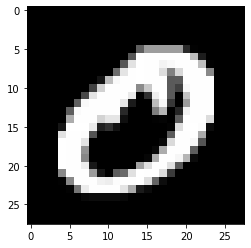

In [4]:
data1_ = val_X[3633, :, :, :]
print(val_y[3633])
plt.imshow(data1_, cmap="Greys_r")

In [5]:
model = keras.Sequential([
    
    preprocessing.RandomRotation(factor=0.05, fill_mode='constant'),     # 18 degrees
    preprocessing.RandomZoom(height_factor=(-0.2,0.2), width_factor=(-0.2,0.2), fill_mode='constant'),  # 20%
    
    layers.Conv2D(filters=16, kernel_size=(5,5), activation="relu", padding="same"),
    layers.MaxPool2D(pool_size=(2,2), padding=("same")),
    
    layers.Conv2D(filters=32, kernel_size=(5,5), activation="relu", padding="same"),
    layers.MaxPool2D(pool_size=(2,2), padding=("same")),
    
    layers.Conv2D(filters=32, kernel_size=(5,5), activation="relu", padding="same"),
    layers.MaxPool2D(pool_size=(2,2), padding=("same")),
    
    layers.Flatten(),
    
    layers.Dense(units=512, activation="relu"),
    layers.BatchNormalization(),
    layers.Dense(units=1024, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(units=512, activation="relu"),
    layers.BatchNormalization(),
    layers.Dense(units=10, activation="softmax"),
])
model.build([None, 28, 28, 1]) # `input_shape` is the shape of the input data
                         # e.g. input_shape = (None, 32, 32, 3)
model.summary()

2022-06-30 11:34:04.800378: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-30 11:34:04.912095: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-30 11:34:04.912995: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-30 11:34:04.916347: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_rotation (RandomRotat (None, 28, 28, 1)         0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          2

In [6]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=1000,
    decay_rate=0.9
)
model.compile(    
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=tf.keras.metrics.SparseCategoricalAccuracy()
)

In [7]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=30,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    train_X, train_y,
    validation_data=(val_X, val_y),
    shuffle = True,
    batch_size=512,
    callbacks=[early_stopping],
    epochs=100,
    verbose=True
)

2022-06-30 11:34:08.341255: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-06-30 11:34:10.797166: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


73/73 [==============================] - 10s 17ms/step - loss: 0.5325 - sparse_categorical_accuracy: 0.8698 - val_loss: 0.6115 - val_sparse_categorical_accuracy: 0.8826
Epoch 2/100
73/73 [==============================] - 1s 12ms/step - loss: 0.1139 - sparse_categorical_accuracy: 0.9646 - val_loss: 0.2219 - val_sparse_categorical_accuracy: 0.9514
Epoch 3/100
73/73 [==============================] - 1s 12ms/step - loss: 0.0826 - sparse_categorical_accuracy: 0.9743 - val_loss: 0.1485 - val_sparse_categorical_accuracy: 0.9666
Epoch 4/100
73/73 [==============================] - 1s 12ms/step - loss: 0.0739 - sparse_categorical_accuracy: 0.9765 - val_loss: 0.1338 - val_sparse_categorical_accuracy: 0.9702
Epoch 5/100
73/73 [==============================] - 1s 12ms/step - loss: 0.0601 - sparse_categorical_accuracy: 0.9805 - val_loss: 0.1153 - val_sparse_categorical_accuracy: 0.9690
Epoch 6/100
73/73 [==============================] - 1s 12ms/step - loss: 0.0562 - sparse_categorical_accuracy:

<AxesSubplot:title={'center':'Accuracy'}>

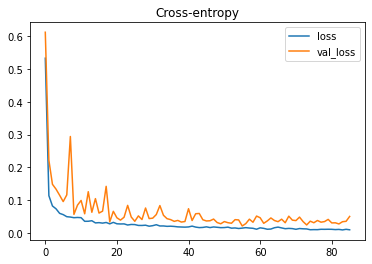

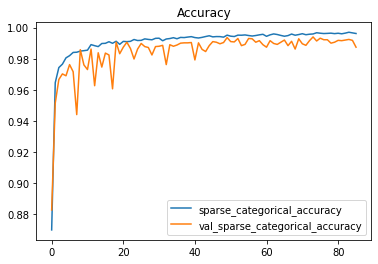

In [8]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot(title="Accuracy")

In [9]:
test = pd.read_csv("../input/digit-recognizer/test.csv")/255
test_index = test.index
test_data = test.values.reshape(-1, 28, 28, 1)

test_preds = np.zeros((1, 1))
test_preds = test_preds + model.predict(test_data)
test_preds = np.argmax(test_preds, axis=1)

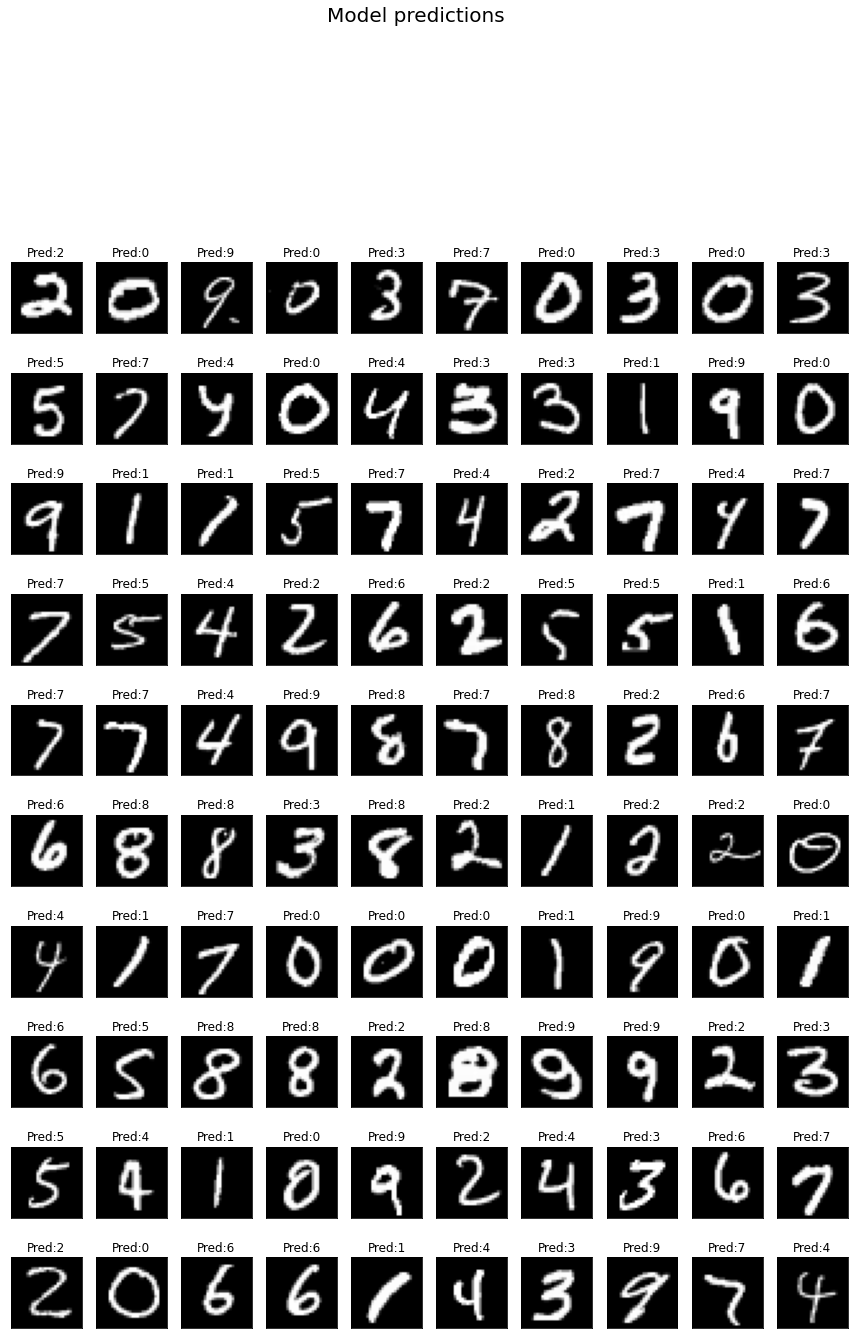

In [10]:
# Plot some model predictions
plt.figure(figsize=(15,20))
plt.suptitle('Model predictions', fontsize=20, y=1.05)

# Subplot
for i in range(100):
    img = test_data[i];
    ax=plt.subplot(10, 10, i+1)
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.title.set_text(f'Pred:{test_preds[i]}')
    plt.imshow(img, cmap='gray')
    
plt.show()

In [11]:
# Save predictions to file
output = pd.DataFrame({'ImageId': test_index+1,
                       'Label': test_preds})

# Check format
output.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [12]:
output.to_csv('submission.csv', index=False)